# Fitting EfficientNet-B0 Model for Traffic Sign Classification

In [37]:
from fontTools.ufoLib.glifLib import layerInfoVersion3ValueData
from pandas.io.sas.sas_constants import dataset_length

!python -m pip install pandas numpy matplotlib seaborn tqdm

The below specifies the packages we need to download

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from PIL import Image, ImageEnhance

This chunk extracts the data from the zip file, and saves it into a "raw data" file on my laptop.

In [3]:
os.chdir("C:/Projects/DST_Project2")
print("Current directory:", os.getcwd())

Current directory: C:\Projects\DST_Project2


In [11]:
import zipfile

# 1. Change working directory
os.chdir("C:/Projects/DST_Project2")
print("Current directory:", os.getcwd())

# 2. Path to ZIP file
zip_path = "C:/Users/Nevaf/PycharmProjects/DataScienceToolbox-Project2/Neva/traffic_raw.zip"  # <-- full path including .zip

# 3. Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("C:/Neva/data")  # Extract to folder
print("ZIP extracted successfully!")

Current directory: C:\Users\Nevaf\PycharmProjects\DataScienceToolbox-Project2\Neva
ZIP extracted successfully!


# EfficientNet-B0 Model Fitting

STEP 1: INSTALL DEPENDENCIES

In [ ]:
""""EfficientNet-B0 model fitting and fine tuning.

Here we implement transfer learning using EfficientNet-B0 for classifying traffic signs from the German Traffic Sign Recognition Benchmark (GTSRB)

The following script shows:
- Dataset preparation
- Random 50% class-balanced downsampling
- Data augmentation and preprocessing
- Transfer learning with pretrained model EfficientNet-B0
- Fine-tuning of final layers
- Visualisation of model accuracy

The code is annotated with markdown and NumPy docstrings
"""

In [4]:
import os
import copy 
import numpy as np
from typing import Tuple, Dict, List
from PIL import Image
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset , random_split
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm #installs a progress bar for epochs


We've installed and imported all necessary libraries and functions.

In [5]:
class Config:
    """Configuration parameters for model training."""

    # Device configuration
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    IMG_SIZE = 224 # necessary for EfficientNet
    BATCH_SIZE = 32
    NUM_CLASSES = 43
    EPOCHS = 10
    LEARNING_RATE = 1e-3
    FINE_TUNE_LR = 1e-4

    SEED = 1
    TRAIN_SPLIT = 0.8
    PATIENCE = 5

    #Paths
    DATA_DIR = Path("data/raw/Train")
    MODEL_SAVE_PATH = Path("models/efficientnet_best.pth")

Prepare the dataset after EDA. We select 50% of the images per class to fit a model to, and we create a custom dataset class.

In [6]:
print(os.getcwd())  # confirms current working directory


C:\Projects\DST_Project2


In [7]:
class TrafficSignDataset(Dataset):
    """
    Custom dataset for our model.

    Parameters:
    ----------
    filepaths : List[str]
    List of paths to image files.
    transform : torchvision.transforms.Compose
    Image transformations applied to the images.

    Attributes:
    ------------
    filepaths : List[str]
    List of paths to image files.
    transform : torchvision.transforms.Compose
    Image transformations applied to the images.
    """

    def __init__(self, filepaths: List[str], transform=None):
        self.filepaths = filepaths
        self.transform = transform

    def __len__(self) -> int:
        return len(self.filepaths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int] :
        """
    Take a single sample from the dataset.

    Parameters:
    ------------
    idx : int
    Index of the single sample.

    Returns:
    ----------
    Tuple[torch.Tensor, int]
    The image tensor and its corresponding class index.
    """
        path = self.filepaths[idx]
        img = Image.open(path).convert("RGB")

        # Extract label from the directory structure
        label = int(os.path.basename(os.path.dirname(path)))
        
        if self.transform:
            img = self.transform(img)
        else:
            # Use default transformation
            img = transforms.ToTensor()(img)

        return img, label


Now we apply data augmentatio, as is standard practice despite our data set already being large and varied. We are not using AutoAugment as some of its features have a negative effect (i.e vertical reflection changes "RH Turn" to "LH turn)

In [8]:
def prepare_data(config: Config) -> Tuple[DataLoader, DataLoader]:
    """
    Prepare the train and validation data loaders.

    Parameters
    ----------
    config : Config
        Configuration object with hyperparameters

    Returns
    -------
    Tuple[DataLoader, DataLoader]
        Training and validation data loaders
    """
    # Set random seed for reproducibility
    torch.manual_seed(config.SEED)
    np.random.seed(config.SEED)

    # Collect all image paths
    all_filepaths = []
    classes = sorted([d for d in os.listdir(config.DATA_DIR)
                     if os.path.isdir(config.DATA_DIR / d)])

    for class_id in classes:
        class_dir = config.DATA_DIR / class_id
        files = [str(class_dir / f) for f in os.listdir(class_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm'))]

        # Downsampling: 50% of images per class
        sample_size = len(files) // 2
        sampled_files = np.random.choice(files, sample_size, replace=False)
        all_filepaths.extend(sampled_files)

    print(f"Total images after sampling: {len(all_filepaths)}")

    # Define transforms
    train_transforms = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNet statistics
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create dataset and split
    full_dataset = TrafficSignDataset(all_filepaths)

    train_size = int(config.TRAIN_SPLIT * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(
        full_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(config.SEED)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transforms
    val_dataset.dataset.transform = val_transforms

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # for Windows compatibility
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return train_loader, val_loader


# Model Building

In [9]:
def build_model(config: Config, freeze_base: bool = True) -> nn.Module:
    """
    Build EfficientNet-B0 model with custom classifier.

    Parameters
    ----------
    config : Config
        Configuration object
    freeze_base : bool, default=True
        Freeze the base model weights for initial training

    Returns
    -------
    nn.Module
        Complete model ready for training
    """
    # Load pre-trained EfficientNet
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    base_model = efficientnet_b0(weights=weights)

    # Remove original classifier
    base_model.classifier = nn.Identity()

    # Freeze base model
    if freeze_base:
        for param in base_model.parameters():
            param.requires_grad = False

    # Build complete model with custom classifier
    model = nn.Sequential(
        base_model,
        nn.Linear(1280, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, config.NUM_CLASSES)
    )

    return model.to(config.DEVICE)


## Define Training Functions

In [10]:
def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> Tuple[float, float]:
    """
    Train model for one epoch.

    Parameters
    ----------
    model : nn.Module
        Model to train
    train_loader : DataLoader
        Training data loader
    criterion : nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    device : torch.device
        Device to train on

    Returns
    -------
    Tuple[float, float]
        Average loss and accuracy for the epoch
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()


    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    return epoch_loss, epoch_acc


def validate(model: nn.Module,
            val_loader: DataLoader,
            criterion: nn.Module,
            device: torch.device) -> Tuple[float, float]:
    """
    Validate model.

    Parameters
    ----------
    model : nn.Module
        Model to validate
    val_loader : DataLoader
        Validation data loader
    criterion : nn.Module
        Loss function
    device : torch.device
        Device to run validation on

    Returns
    -------
    Tuple[float, float]
        Validation loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects / len(val_loader.dataset)

    return val_loss, val_acc


def train_model(model: nn.Module,
               train_loader: DataLoader,
               val_loader: DataLoader,
               config: Config,
               optimizer=None,
               epochs=None,
               save_path=None) -> Dict:
    """
    Complete training loop with early stopping.

    Parameters
    ----------
    model : nn.Module
        Model to train
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    config : Config
        Configuration object
    optimizer : torch.optim.Optimizer, optional
        Custom optimizer (if None, creates default Adam)
    epochs : int, optional
        Number of epochs (if None, uses config.EPOCHS)
    save_path : Path, optional
        Path to save best model (if None, uses config.MODEL_SAVE_PATH)
    Returns
    -------
    Dict
        Training history with losses and accuracies
    """

    criterion = nn.CrossEntropyLoss()

    if optimizer is None:
        optimizer = Adam(model.parameters(), lr=config.LEARNING_RATE)

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
    num_epochs = epochs if epochs is not None else config.EPOCHS
    model_save_path = save_path if save_path is not None else config.MODEL_SAVE_PATH

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [],
               'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, config.DEVICE
        )

        # Validate
        val_loss, val_acc = validate(
            model, val_loader, criterion, config.DEVICE
        )

        # Update scheduler
        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0

            # Save best model
            model_save_path.parent.mkdir(parents=True, exist_ok=True)
            torch.save(best_model_state, model_save_path)
        else:
            patience_counter += 1
            if patience_counter >= config.PATIENCE:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return history


In [11]:
def progressive_fine_tuning(model: nn.Module,
                           train_loader: DataLoader,
                           val_loader: DataLoader,
                           config: Config) -> Dict:
    """
    Implement progressive fine-tuning strategy.

    Stage 1: Train classifier only (frozen backbone)
    Stage 2: Unfreeze last 2 blocks + classifier
    Stage 3 (optional): Full fine-tuning

    Parameters
    ----------
    model : nn.Module
        Model to fine-tune (must be the Sequential model from build_model)
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader
    config : Config
        Configuration object

    Returns
    -------
    Dict
        Complete training history from all stages
    """

    if not isinstance(model, nn.Sequential) or len(model) < 4:
        raise ValueError("Model must be Sequential with at least 4 layers")

    base_model = model[0]  # EfficientNet base
    fc1 = model[1]         # First FC layer
    fc2 = model[3]         # Second FC layer (after ReLU and Dropout)

    print("\n" + "="*70)
    print("PROGRESSIVE FINE-TUNING")
    print("="*70)

    # STAGE 1: Train classifier only (backbone frozen)

    print("\n" + "="*70)
    print("STAGE 1: Training classifier only (backbone frozen)")
    print("="*70)

    # Freeze entire backbone
    for param in base_model.parameters():
        param.requires_grad = False

    # Only train classifier layers
    trainable_params = list(fc1.parameters()) + list(fc2.parameters())
    optimizer_stage1 = Adam(trainable_params, lr=1e-3)

    # Train for fewer epochs in stage 1
    history_stage1 = train_model(
        model,
        train_loader,
        val_loader,
        config,
        optimizer=optimizer_stage1,
        epochs=5,
        save_path=Path("models/efficientnet_stage1.pth")
    )

    print(f"\nStage 1 complete - Best val acc: {max(history_stage1['val_acc']):.4f}")


    # STAGE 2: Unfreeze last 2 blocks + continue training

    print("\n" + "="*70)
    print("STAGE 2: Fine-tuning last 2 feature blocks")
    print("="*70)

    # Unfreeze only the last 2 blocks (features.6 and features.7)
    num_unfrozen = 0
    for name, param in base_model.named_parameters():
        if name.startswith("features.6") or name.startswith("features.7"):
            param.requires_grad = True
            num_unfrozen += 1

    print(f"Unfrozen {num_unfrozen} parameters in last 2 blocks")

    # Use different learning rates for backbone vs classifier
    # Lower LR for pre-trained layers, higher for classifier
    optimizer_stage2 = Adam([
        {'params': base_model.features[6].parameters(), 'lr': 1e-5},
        {'params': base_model.features[7].parameters(), 'lr': 1e-5},
        {'params': fc1.parameters(), 'lr': 1e-4},
        {'params': fc2.parameters(), 'lr': 1e-4}
    ])

    history_stage2 = train_model(
        model,
        train_loader,
        val_loader,
        config,
        optimizer=optimizer_stage2,
        epochs=5,
        save_path=Path("models/efficientnet_stage2.pth")
    )

    print(f"\nStage 2 complete - Best val acc: {max(history_stage2['val_acc']):.4f}")

    # Combine histories

    combined_history = {
        'train_loss': history_stage1['train_loss'] + history_stage2['train_loss'],
        'train_acc': history_stage1['train_acc'] + history_stage2['train_acc'],
        'val_loss': history_stage1['val_loss'] + history_stage2['val_loss'],
        'val_acc': history_stage1['val_acc'] + history_stage2['val_acc'],
        'stage1': history_stage1,
        'stage2': history_stage2
    }

    print("\n" + "="*70)
    print("PROGRESSIVE FINE-TUNING COMPLETE")
    print("="*70)
    print(f"Stage 1 best val acc: {max(history_stage1['val_acc']):.4f}")
    print(f"Stage 2 best val acc: {max(history_stage2['val_acc']):.4f}")
    print(f"Improvement: {max(history_stage2['val_acc']) - max(history_stage1['val_acc']):.4f}")

    return combined_history


## Plot Fine Tuning Results

In [12]:
def plot_progressive_fine_tuning(history: Dict, save_path='progressive_finetuning.png'):
    """
    Plot the results of progressive fine-tuning.

    Parameters
    ----------
    history : Dict
        History dict from progressive_fine_tuning()
    save_path : str
        Where to save the plot
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    epochs = list(range(1, len(history['train_loss']) + 1))
    stage1_end = len(history['stage1']['train_loss'])

    # Plot loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[0].axvline(x=stage1_end, color='g', linestyle='--',
                    label='Stage 1 → Stage 2')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Progressive Fine-tuning: Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[1].axvline(x=stage1_end, color='g', linestyle='--',
                    label='Stage 1 → Stage 2')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Progressive Fine-tuning: Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Plot saved to {save_path}")

## Main Execution

Using device: cpu
Number of classes: 43

Preparing data...
Total images after sampling: 19604

Building model...

Using PROGRESSIVE FINE-TUNING strategy

PROGRESSIVE FINE-TUNING

STAGE 1: Training classifier only (backbone frozen)

Epoch 1/5


Training: 100%|██████████| 491/491 [13:49<00:00,  1.69s/it]


Train Loss: 1.9083 Acc: 0.5202
Val   Loss: 1.1073 Acc: 0.7381

Epoch 2/5


Training: 100%|██████████| 491/491 [12:20<00:00,  1.51s/it]


Train Loss: 1.1671 Acc: 0.6871
Val   Loss: 0.8211 Acc: 0.7939

Epoch 3/5


Training: 100%|██████████| 491/491 [11:58<00:00,  1.46s/it]


Train Loss: 0.9567 Acc: 0.7402
Val   Loss: 0.6974 Acc: 0.8299

Epoch 4/5


Training: 100%|██████████| 491/491 [11:31<00:00,  1.41s/it]


Train Loss: 0.8415 Acc: 0.7687
Val   Loss: 0.6510 Acc: 0.8330

Epoch 5/5


Training: 100%|██████████| 491/491 [11:21<00:00,  1.39s/it]


Train Loss: 0.7639 Acc: 0.7877
Val   Loss: 0.5661 Acc: 0.8564

Stage 1 complete - Best val acc: 0.8564

STAGE 2: Fine-tuning last 2 feature blocks
Unfrozen 65 parameters in last 2 blocks

Epoch 1/5


Training: 100%|██████████| 491/491 [16:10<00:00,  1.98s/it]


Train Loss: 0.5762 Acc: 0.8373
Val   Loss: 0.3758 Acc: 0.8929

Epoch 2/5


Training: 100%|██████████| 491/491 [16:18<00:00,  1.99s/it]


Train Loss: 0.4397 Acc: 0.8751
Val   Loss: 0.2827 Acc: 0.9222

Epoch 3/5


Training: 100%|██████████| 491/491 [17:05<00:00,  2.09s/it]


Train Loss: 0.3591 Acc: 0.8949
Val   Loss: 0.2267 Acc: 0.9360

Epoch 4/5


Training: 100%|██████████| 491/491 [16:29<00:00,  2.01s/it]


Train Loss: 0.3172 Acc: 0.9057
Val   Loss: 0.1945 Acc: 0.9454

Epoch 5/5


Training: 100%|██████████| 491/491 [17:06<00:00,  2.09s/it]


Train Loss: 0.2681 Acc: 0.9253
Val   Loss: 0.1700 Acc: 0.9541

Stage 2 complete - Best val acc: 0.9541

PROGRESSIVE FINE-TUNING COMPLETE
Stage 1 best val acc: 0.8564
Stage 2 best val acc: 0.9541
Improvement: 0.0977


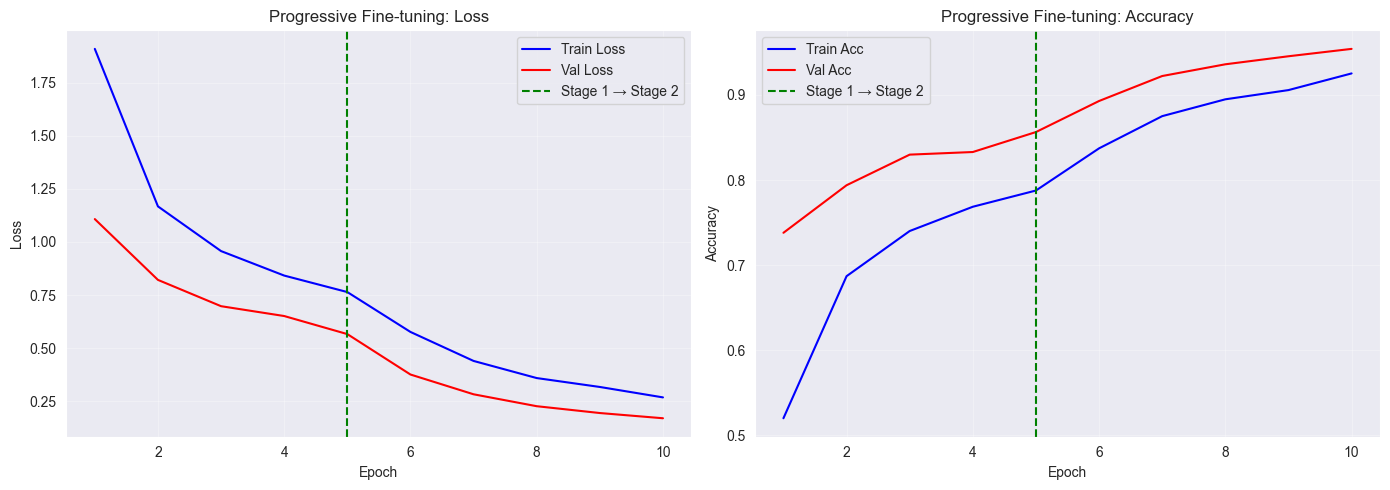

Plot saved to progressive_finetuning.png

Training complete!
Best validation accuracy: 0.9541


In [13]:
def main():
    """Main execution function."""
    # Initialize configuration
    config = Config()

    print(f"Using device: {config.DEVICE}")
    print(f"Number of classes: {config.NUM_CLASSES}")

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader = prepare_data(config)

    # Build model
    print("\nBuilding model...")
    model = build_model(config, freeze_base=True)

    # Choose training strategy
    use_progressive = True  # Set to False for standard training

    if use_progressive:
        print("\nUsing PROGRESSIVE FINE-TUNING strategy")
        history = progressive_fine_tuning(model, train_loader, val_loader, config)

        # Plot results
        plot_progressive_fine_tuning(history)

        # Save final model
        torch.save(model.state_dict(), "models/efficientnet_final.pth")
    else:
        print("\nUsing STANDARD training")
        history = train_model(model, train_loader, val_loader, config)

    print("\nTraining complete!")
    print(f"Best validation accuracy: {max(history['val_acc']):.4f}")

    return model, history


if __name__ == "__main__":
    model, history = main()

In [18]:
!python -m pip install scikit-learn
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


The system cannot find the file C:\Users\Nevaf\AppData\Local\Microsoft\WindowsApps\python.exe.


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(
    all_labels, 
    all_preds,
    zero_division = 0))



above gives classification report: precision, recall, f1 per class. now we do confusion matrix heat map

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


now time for few shot learning. shows how accuracy drops under small data conditions

In [ ]:
import os
os.getcwd()
